# Libraries

In [ ]:
import tensorflow as tf
import random
import numpy as np 
SEED = 10
random.seed(SEED)       # Sets seed for Python's built-in random module
np.random.seed(SEED)    # Sets seed for NumPy's random functions
tf.random.set_seed(SEED)  # Sets seed for TensorFlow's random operations

# Dataset

Minst Dataset

*   60,000 training images
*   10,000 test images
*   28x28 pixels (784 pixels)
*   Grayscale
*   Labled






In [ ]:
# Load and preprocess MNIST
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

#Normalization
x_train = x_train.reshape(-1, 784).astype(np.float32) / 255.0
x_test = x_test.reshape(-1, 784).astype(np.float32) / 255.0

#One-Hot-Encoding
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

#Training Set
x_train_subset = x_train[:5000]
y_train_subset = y_train[:5000]

#Testing Set
x_test_subset = x_test[:10000]
y_test_subset = y_test[:10000]

# Neural Network

In [ ]:
#ReLU activation (for hidden layer)
def relu(x):
    return np.maximum(0, x)

#Softmax activation (for output layer)
def softmax(x):
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))#We subtract to avoid big numbers when we take the exponential,This helps with numerical stability.
    return e_x / np.sum(e_x, axis=1, keepdims=True)

# Vector decoding (update dimensions to match 32 hidden units)
def decode_vector(vector):
    W1 = vector[0:25088].reshape((784, 32))
    b1 = vector[25088:25120].reshape((32,))
    W2 = vector[25120:25440].reshape((32, 10))
    b2 = vector[25440:25450].reshape((10,))
    return W1, b1, W2, b2

# Model forward pass
def forward(X, W1, b1, W2, b2):
    Z1 = X @ W1 + b1      # Linear part
    A1 = relu(Z1)         # Apply ReLU
    Z2 = A1 @ W2 + b2     # Linear part
    A2 = softmax(Z2)      # Apply softmax
    return A2

def cross_entropy(preds, targets, eps=1e-12):
    preds = np.clip(preds, eps, 1 - eps)  # Avoid log(0) which is undefined and log(1) as it is = 0 , range = (eps , 1 - eps)
    return -np.mean(np.sum(targets * np.log(preds), axis=1))

def fitness_function(vector):
    #Vector Decoding
    W1, b1, W2, b2 = decode_vector(vector)

    #Forward pass
    probs = forward(x_train_subset, W1, b1, W2, b2)

    #Cross-entropy loss
    ce_loss = cross_entropy(probs, y_train_subset)

    return ce_loss

# He initialization for 32 ReLU units , ""weight = np.random.randn(...) * sqrt(2 / n)""scaling the randoms
def he_vector(input_dim=784, hidden_dim=32, output_dim=10):
    w1 = np.random.randn(input_dim, hidden_dim) * np.sqrt(2 / input_dim)
    b1 = np.zeros(hidden_dim)
    w2 = np.random.randn(hidden_dim, output_dim) * np.sqrt(2 / hidden_dim)
    b2 = np.zeros(output_dim)
    return np.concatenate([w1.flatten(), b1, w2.flatten(), b2])

# Differential Evolution

In [ ]:
def de_step(pop, fit, F, CR, strategy):
    size, dim = pop.shape
    new_pop = np.empty_like(pop)
    new_fit = np.empty(size)
    best = pop[np.argmin(fit)]

    for i in range(size):
        xi = pop[i]
        idxs = np.delete(np.arange(size), i)
        r = pop[np.random.choice(idxs, 5, replace=False)]

        # Mutation
        if strategy == 'rand/1':
            mutant = r[0] + F * (r[1] - r[2])
        elif strategy == 'best/1':
            mutant = best + F * (r[0] - r[1])
        elif strategy == 'current-to-best/1':
            mutant = xi + F * (best - xi) + F * (r[0] - r[1])
        elif strategy == 'rand/2':
            mutant = r[0] + F * (r[1] - r[2]) + F * (r[3] - r[4])
        else:
            raise ValueError("Unknown strategy")

        # Crossover
        mask = np.random.rand(dim) < CR
        if not np.any(mask):  # Ensure at least one gene is changed
            mask[np.random.randint(dim)] = True
        trial = np.where(mask, mutant, xi)

        # Selection
        trial_fit = fitness_function(trial)
        if trial_fit <= fit[i]:
            new_pop[i], new_fit[i] = trial, trial_fit
        else:
            new_pop[i], new_fit[i] = xi, fit[i]

    return new_pop, new_fit

# Island Model

In [ ]:
from joblib import Parallel, delayed
# === Parallel fitness evaluation helper ===
def parallel_fitness(pop):
    return np.array(Parallel(n_jobs=-1)(delayed(fitness_function)(ind) for ind in pop))

In [ ]:
def init_islands(pop_size, num_islands):
    total_size = pop_size * num_islands
    total_pop = np.array([he_vector() for _ in range(total_size)])
    total_fit = parallel_fitness(total_pop)

    # Randomly shuffle and split into islands
    indices = np.random.permutation(total_size)
    pop_shuffled = total_pop[indices]
    fit_shuffled = total_fit[indices]

    islands = np.array_split(pop_shuffled, num_islands)
    fits = np.array_split(fit_shuffled, num_islands)

    return list(islands), list(fits)

In [ ]:
def island_model(vector_size, pop_size=20, generations=5000, migration_interval=50, num_islands=4):
    strategies = ['rand/1', 'best/1', 'current-to-best/1', 'rand/2']
    F_vals = [0.7, 0.7, 0.7, 0.7]
    CR_vals = [0.8, 0.8, 0.8, 0.8]
    islands, fits = init_islands(pop_size, num_islands)
    loss_history = []

    for gen in range(generations):
        # Evolution step for each island
        for i in range(num_islands):
            islands[i], fits[i] = de_step(
                islands[i], fits[i], F_vals[i], CR_vals[i], strategies[i]
            )

        # Migration step (ring topology)
        if gen % migration_interval == 0 and gen > 0:
            migrant_pool = [island[np.random.choice(pop_size, 2, replace=False)]
                            for island in islands]

            for i in range(num_islands):
                next_i = (i + 1) % num_islands

                # Get indices of 2 worst individuals in the destination island
                worst_indices = np.argsort(-fits[next_i])[:2]

                # Replace them with migrants
                islands[next_i][worst_indices] = migrant_pool[i]
                fits[next_i][worst_indices] = parallel_fitness(migrant_pool[i])

        # Log best loss every generation
        best_loss = min(np.min(f) for f in fits)
        loss_history.append(best_loss)

        # Logging every 100 generations
        if gen % 100 == 0:
            print(f"[Gen {gen:04d}] Best Loss: {best_loss:.4f}")
            for i in range(num_islands):
                best = np.min(fits[i])
                avg = np.mean(fits[i])
                print(f"  Island {i+1:<2} | Best: {best:.4f} | Avg: {avg:.4f}")

    # Final return: best individual from all islands
    all_pop = np.vstack(islands)
    all_fit = np.concatenate(fits)
    return all_pop[np.argmin(all_fit)] , loss_history

# Run

In [ ]:
# Set seed for reproducibility
np.random.seed(SEED)
best_solution ,loss_history = island_model(vector_size=25450 )

[Gen 0000] Best Loss: 2.2867
  Island 1  | Best: 2.3149 | Avg: 2.4342
  Island 2  | Best: 2.2880 | Avg: 2.3727
  Island 3  | Best: 2.3155 | Avg: 2.3845
  Island 4  | Best: 2.2867 | Avg: 2.4096
[Gen 0100] Best Loss: 1.5522
  Island 1  | Best: 2.2166 | Avg: 2.2837
  Island 2  | Best: 1.5522 | Avg: 1.6560
  Island 3  | Best: 1.5652 | Avg: 1.5819
  Island 4  | Best: 1.5833 | Avg: 2.2474
[Gen 0200] Best Loss: 1.0669
  Island 1  | Best: 1.9655 | Avg: 2.2222
  Island 2  | Best: 1.0669 | Avg: 1.1931
  Island 3  | Best: 1.0698 | Avg: 1.3224
  Island 4  | Best: 1.2355 | Avg: 1.9615
[Gen 0300] Best Loss: 0.8669
  Island 1  | Best: 1.2355 | Avg: 1.9935
  Island 2  | Best: 0.8669 | Avg: 0.9914
  Island 3  | Best: 0.8720 | Avg: 1.1556
  Island 4  | Best: 0.9134 | Avg: 1.5127
[Gen 0400] Best Loss: 0.7442
  Island 1  | Best: 0.9134 | Avg: 1.6105
  Island 2  | Best: 0.7442 | Avg: 0.8488
  Island 3  | Best: 0.7489 | Avg: 0.9666
  Island 4  | Best: 0.7592 | Avg: 1.2548
[Gen 0500] Best Loss: 0.6722
  Isla

# Plot

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
# Decode weights and predict
decoded_weights = decode_vector(best_solution)
predictions_test = forward(x_test_subset, *decoded_weights)
predictions_train = forward(x_train_subset, *decoded_weights)

# Labels and accuracy
predicted_labels = np.argmax(predictions_test, axis=1)
true_labels = np.argmax(y_test_subset, axis=1)
test_accuracy = np.mean(predicted_labels == true_labels)
train_accuracy = np.mean(np.argmax(predictions_train, axis=1) == np.argmax(y_train_subset, axis=1))

print(f"\nFinal Train Accuracy: {train_accuracy * 100:.2f}%")
print(f"Final Test Accuracy: {test_accuracy * 100:.2f}%")


Final Train Accuracy: 96.04%
Final Test Accuracy: 88.99%


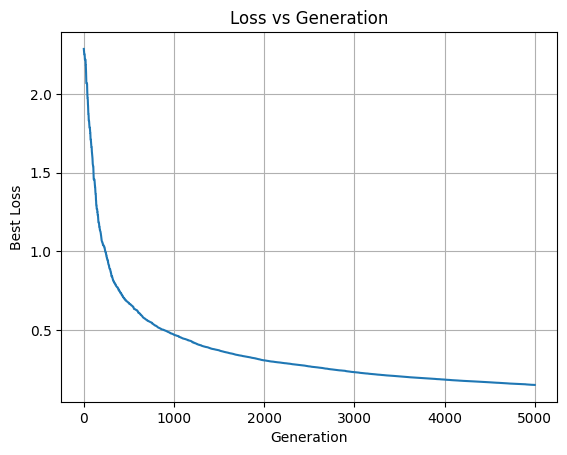

In [ ]:
# Plot loss per generation
plt.plot(loss_history, label='Loss')
plt.xlabel('Generation')
plt.ylabel('Best Loss')
plt.title('Loss vs Generation')
plt.grid(True)
plt.show()

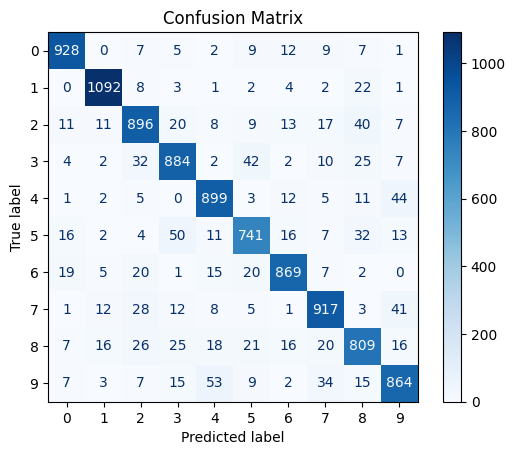

In [ ]:
# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()